# Forecasting with a Bespoke Model
Now that I have a basic model working, I wanted to try something more involved. The next method for forecasting sales that should be used is to use a bespoke time-series model.

In this case I model the current dataset and try to predict using that model. I decided to fit multiple sine functions to the data, to represent the weekly and monthly trends. This is done in quite a simplistic but novel way but dampening noise in different ways using a moving average function. This makes long term trends and short term trends easier to see.


### Import packages, read pickle file

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
pd.options.display.max_seq_items = 2000

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

### Impute missing product band

create the function using values fitted in notebook 5, then apply that funciton to create a new column containing the new product band sales (for 30to40). Check the header to see if values have been created correctly.

In [3]:

def salescount_poisson(B12,B23):
    """
    Function to estimate sales for the productBand 30to40 using two other product bands.
    """
    var1,var2=0.7552276624532916,0.5290400984433794
    return (var1*B12+var2*B23)/2.


In [4]:
forecast_august=df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0)
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount_poisson(x['between10and20'],x['between20and30']),axis=1)
forecast_august.drop(forecast_august.index[len(forecast_august)-1],inplace=True)
forecast_august

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing,between30and40
date,,,,,,,
2018-07-01,219.0,230.0,41.0,160.0,18.0,42.0,143.537040
2018-07-02,247.0,269.0,32.0,195.0,32.0,60.0,164.426510
2018-07-03,246.0,286.0,22.0,121.0,26.0,55.0,168.545737
2018-07-04,206.0,250.0,28.0,182.0,17.0,52.0,143.918462
2018-07-05,242.0,271.0,47.0,179.0,27.0,51.0,163.067480
2018-07-06,188.0,231.0,41.0,172.0,26.0,46.0,132.095532
2018-07-07,204.0,233.0,34.0,162.0,8.0,18.0,138.666393
2018-07-08,216.0,239.0,39.0,156.0,21.0,21.0,144.784879
2018-07-09,256.0,298.0,52.0,257.0,25.0,35.0,175.496115


### Fitting the model
The movingaverage function is more important in this model. It is used to smooth the data, so that monthly and weekly trends can be modeled one after the other.

In [5]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

## Forecast New Line
first look at the current data for the new line. The sales for July and half of August are avalible for the new line, we just need to forecast for the last two weeks of august.

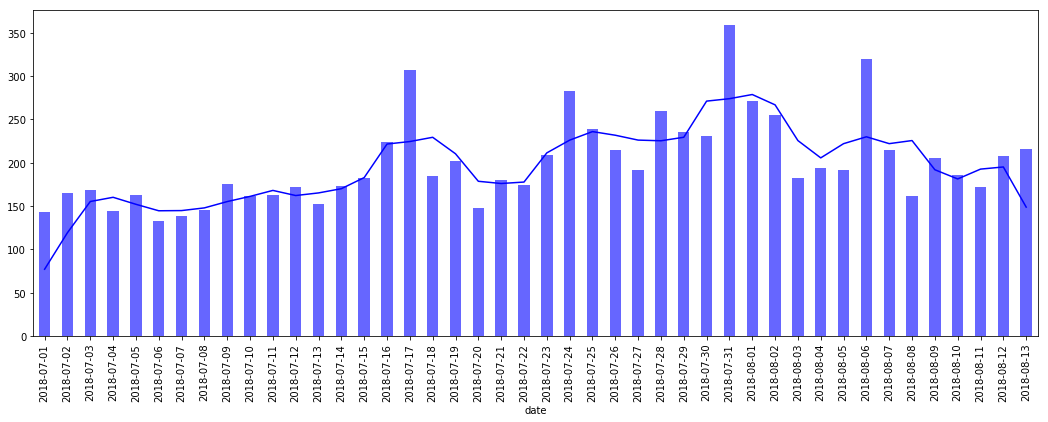

In [6]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
move_av_30to40=movingaverage(forecast_august['between30and40'].values,4)
ax.plot(move_av_30to40,color='blue')

#### Forecast Model
I use a simple sine function to model the trends.

In [7]:
def monthly_trend_forecaster(t,x):
    """
    Simple sine function where:
    - x[0]=ampitude
    - x[1]=frequency
    - x[2]=phase
    - x[3]=mean (offset)
    """
    return x[0]*np.sin(x[1]*t+x[2]) + x[3]

Can't use date as the index, so reset index

In [8]:
forecast_august.reset_index(inplace=True)

First we want to forecast the more global trend, the model can be quite sensitive to the initial guess values (this is common for sin function fitting, where you need good guess values). The most important guess value is the frequency (guess_freq).

In [9]:
#between20and30 first
y=movingaverage(forecast_august['between30and40'].values,6)
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 0.3
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o1,cov_o1,infodict,mesg,ier=fullout
perr = np.sqrt(np.diag(cov_o1)) # error is equal to the diagonal of the covariance matrix.
print(o1,perr)
print(np.mean(y))

[-6.39074530e+01  9.86779146e-02 -4.29298086e+00  1.73352286e+02] [0.53500834 0.00078601 0.02181078 0.63348472]
193.40301110216186


Try to calculate a basic error for this calculation

In [10]:
error_comb_o1=np.sqrt((perr[0]/o1[0])**2+(perr[1]/o1[1])**2+(perr[2]/o1[2])**2)+(perr[3]/o1[3])
print(error_comb_o1)

0.016277449040313332


#### Plot the fitted global trend

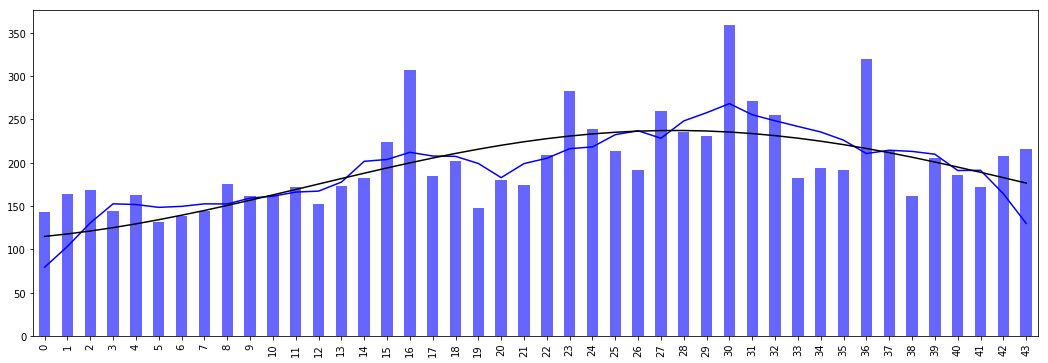

In [11]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(y,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o1),color='k')

#### Model short term trend
Now want to model the short term trend using a smaller moving average smooth. the frequency is also set to be larger.


[ 31.27749142   0.92703647  -1.35993183 197.7715822 ] [[ 4.56080589e-02 -4.79530431e-06  1.03809143e-04  6.36301436e-04]
 [-4.79530431e-06  2.88493349e-07 -6.29788265e-06  2.34550713e-08]
 [ 1.03809143e-04 -6.29788265e-06  1.84113362e-04 -7.17871218e-05]
 [ 6.36301436e-04  2.34550713e-08 -7.17871218e-05  2.28450892e-02]]
197.33508537980117


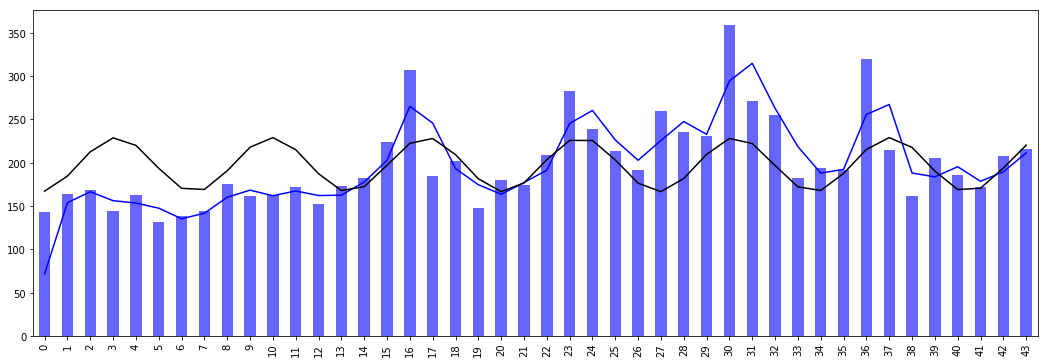

In [25]:
#between20and30 first
move_av_30to40=movingaverage(forecast_august['between30and40'].values,2)
y=move_av_30to40
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 0.8
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
fullout = opt.leastsq(errfunc, guess[:], args=(x1, y),full_output=1)
o2,cov_o2,infodict,mesg,ier=fullout
perr2 = np.sqrt(np.diag(cov_o2))
print(o2,cov_o2)
print(np.mean(y))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o2),color='k')

Again, try to give a crude estimate of the errror

In [26]:
error_comb_o2=np.sqrt((perr2[0]/o2[0])**2+(perr2[1]/o2[1])**2+(perr2[2]/o2[2])**2)+(perr2[3]/o2[3])
print(error_comb_o2)

0.012868315343214741


## Combined Forecasting Model


Combine the error from the two models, as these models will need to be combined later anyway.

In [27]:
error_percent_tot=np.sqrt(error_comb_o1**2+error_comb_o2**2)

Combine the two fitted sine functions to give the forecasting model and plot that model.

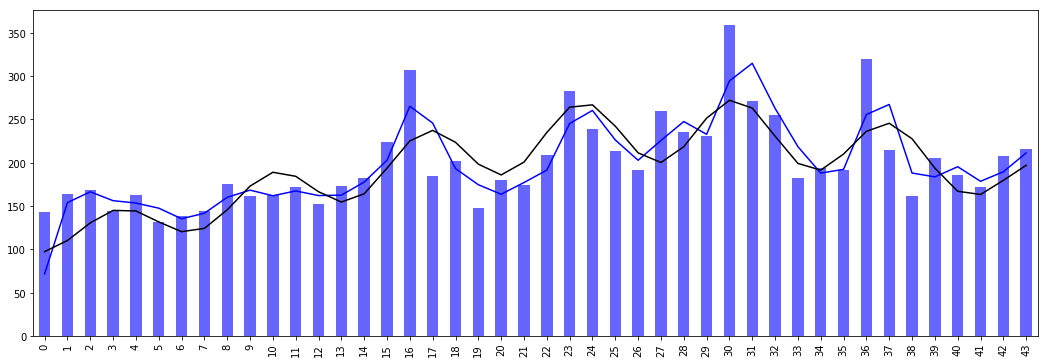

In [28]:
#def comb_func(x1,o1,o2):
#    return (monthly_trend_forecaster(x1,o1)+monthly_trend_forecaster(x1,o2))/2.#This dampens the signal a little, better to use the lower function
def comb_func(x1,o1,o2):
    return (monthly_trend_forecaster(x1,o1)*monthly_trend_forecaster(x1,o2))/np.mean(monthly_trend_forecaster(x1,o2))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,comb_func(x1,o1,o2),color='k')

## Forecast Sales for last two weeks
Now we have modelled the current dataset, we can use this to predict the sales in the future for any productBand. Although we will just do the band 30to40.


##### Note: 
The model does not use the timestamp, but just day, starting from 0. We want to model the last two weeks of August, in coding terms this is from days 44->60

Create an array with the new days, then model the total product sales

In [29]:
newdates=np.arange(44,61,1)
b34sales=comb_func(newdates,o1,o2)

Create a dataframe from this.

In [30]:
df_b34=pd.DataFrame(b34sales,index=newdates)
df_b34

,0
44,195.694254
45,175.025356
46,146.245175
47,127.501736
48,127.942040
49,141.396399
50,152.364829
51,148.671255
52,130.552954
53,109.583746


Assign new dates to this dataframe. starting from 08-14, as this was missing data as well.

In [31]:
import datetime
def assigndates(row):
    r44=pd.to_datetime('2018-08-14')
    year = r44.year
    month = r44.month
    day = r44.day+(row.name-44)
    return datetime.date(year, month, day)
df_b34['date']=df_b34.apply(lambda row:assigndates(row),axis=1)
df_b34

,0,date
44,195.694254,2018-08-14
45,175.025356,2018-08-15
46,146.245175,2018-08-16
47,127.501736,2018-08-17
48,127.942040,2018-08-18
49,141.396399,2018-08-19
50,152.364829,2018-08-20
51,148.671255,2018-08-21
52,130.552954,2018-08-22
53,109.583746,2018-08-23


Assign the date to the index.

In [32]:
df_b34.reset_index(inplace=True)
df_b34.set_index('date',inplace=True)
df_b34.head()

,index,0
date,,
2018-08-14,44,195.694254
2018-08-15,45,175.025356
2018-08-16,46,146.245175
2018-08-17,47,127.501736
2018-08-18,48,127.942040


Drop the old index, then rename the sales index

In [33]:
df_b34.drop(['index'],axis=1,inplace=True)

In [34]:
df_b34.rename(columns={0: "forecast_B30to40"},inplace=True)

Apply the error to the sales forecast, currently a very simple error propagation formulae.

In [35]:
df_b34['forecast_error']=df_b34.apply(lambda x:x*error_percent_tot)
df_b34.head()

,forecast_B30to40,forecast_error
date,,
2018-08-14,195.694254,4.060592
2018-08-15,175.025356,3.631719
2018-08-16,146.245175,3.034539
2018-08-17,127.501736,2.645619
2018-08-18,127.942040,2.654755


### Plot forecasted Sales
This is the final predicted sales for the new product band.

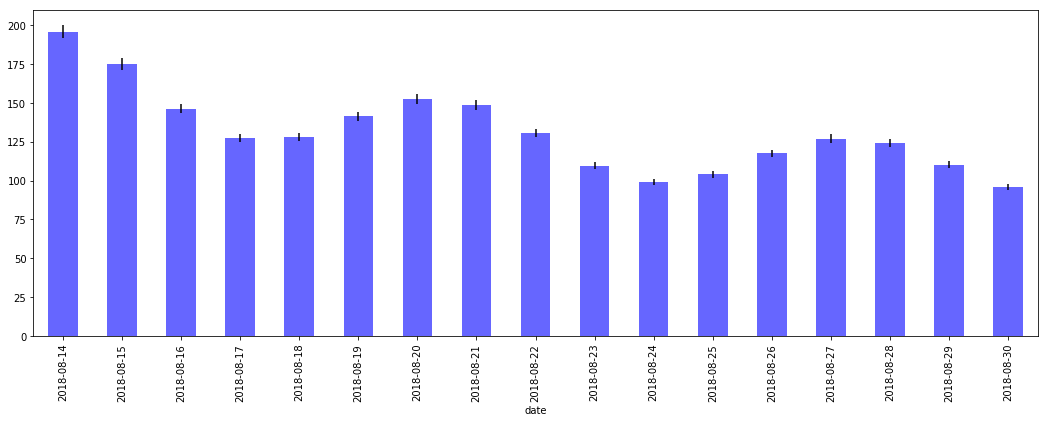

In [36]:
f, ax = plt.subplots(1,figsize=(18,6))
df_b34['forecast_B30to40'].plot(kind='bar',yerr=df_b34['forecast_error'], ax=ax,color='blue',alpha=0.6,label='Forecast_30to40')